<table>
 <tr align=left><td><img align=left src="https://i.creativecommons.org/l/by/4.0/88x31.png">
 <td>Text provided under a Creative Commons Attribution license, CC-BY. All code is made available under the FSF-approved MIT license. (c) Kyle T. Mandli</td>
</table>

In [1]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt

# Hyperbolic Equations - Part I

Hyperbolic equations are well-known to us and arise in many models of physical systems as well as others with wave-like behavior.  One of the most basic hyperbolic PDEs is the advection equation
$$
    u_t + a u_x = 0
$$
where the unknown $u(x,t)$ is some quantity being transported by a flow at speed $a$.  This equation will form the basis of our discussion on this broad topic.

For the Cauchy problem (infinite spatial-domain) we only need an initial condition $u(x,0) = u_0(x)$ with which we can immediately write down the solution of this simple PDE as
$$
    u(x,t) = u_0(x - a t).
$$
This simplicity belies complexity however when it comes to numerical methods to solve this equation.  Luckily this equation demonstrates many of the numerical difficulties with solving more complex hyperbolic PDEs while be exceedingly simple to solve.

If we have finite boundaries on the advection equation note that for consistency we only need one boundary, called the in-flow boundary, and none on the out-flow boundary.  Which boundary is which is determined by the direction of the flow, i.e. the sign of $a$.  Numerically this may cause problems depending on the discretization we use (if we need a point from the out-flow boundary for instance).  Instead in practice we will get around this by numerically setting a boundary that does not conflict with the out going solution or by using a different one-sided approximation.  We will come back to this issue a bit later but it is good to be aware of this as we discuss.

## First Discretizations

The first approach may be to discretize this equation with a forward Euler method in time and second order, centered differences in space leading to the discretization
$$
    \frac{U^{n+1}_j - U^n_j}{\Delta t} = \frac{a}{2 \Delta x} (U^n_{j+1} - U^n_{j-1})
$$
or 
$$
    U^{n+1}_j = U^n_j + \frac{a \Delta t}{2 \Delta x} (U^n_{j+1} - U^n_{j-1}).
$$
It turns out this method is not very useful in practice as will see when considering stability.

Another method that is a minor modification of the above is called the *Lax-Friedrichs method*
$$
    U^{n+1}_j = \frac{1}{2}(U^n_{j-1} + U^n_{j+1}) - \frac{a \Delta t}{2 \Delta x} (U^n_{j+1} - U^n_{j-1}).
$$
This method replaces the single evaluation $U^n_j$ with a spatial average.  Although this approach has better stability properties (it is Lax-Richtmyer stable) it still is not used often in practice.  

Another common discretization of the advection equation is that found from Leapfrog (midpoint).  Using this approach we find
$$
    \frac{U^{n+1}_j - U^{n-1}_j}{2 \Delta t} + a \frac{U^n_{j+1} - U^n_{j-1}}{2 \Delta x} = 0
$$
or in update form
$$
    U^{n+1}_j = U^{n-1}_j - \frac{a \Delta t }{\Delta x} (U^n_{j+1} - U^n_{j-1}).
$$

One final note before moving onto convergence analysis deals with the relation between $\Delta t$ and $\Delta x$.  For the Lax-Friedrichs method for instance we will find the relationship
$$
    \left | \frac{a \Delta t}{\Delta x} \right | \leq 1
$$
which, apart from $a$, shows that $\Delta t$ and $\Delta x$ may change at the same order!  This leads us to the general conclusion that hyperbolic PDEs are in fact less stiff in general that parabolic PDEs due to the derivatives involved.  This is also why hyperbolic PDEs can effectively be solved using explicit time stepping discretizations rather than the implicit ones we found useful for parabolic PDEs.  

## Method of Lines Discretization

As a first pass at understanding the stability of our aforementioned discretizations let's formulate the advection equation in a method of lines approach and analyze the stability in terms of an initial value problem.  

In order to consider all the methods before we will assume periodic boundary conditions (so that they do not have the in-flow/out-flow problem).  These boundary conditions look like
$$
    u(0, t) = u(1, t), ~~~ \text{for}~ t \geq 0
$$
where we have chosen $\Omega = [0, 1]$ for simplicity.  This setup also is similar to the original Cauchy problem.

We now introduce the unknown vector
$$
    U = \begin{bmatrix}
        U_1(t) \\ U_2(t) \\ \vdots \\ U_m(t) \\ U_{m+1}(t)
    \end{bmatrix}
$$
where we have included an extra value at $x_{m+1}$ with the idea that $U_0(t) = U_{m+1}(t)$.  Using this discretization we have the system of ODEs

$$
    U'_j(t) = -\frac{a}{2 \Delta x} \left \{ \begin{aligned}
        &(U_2(t) - U_{m+1}(t)) & & j = 1 \\
        &(U_{j+1}(t) - U_{j-1}(t)) & & 2 \leq j \leq m \\
        &(U_1(t) - U_{m}(t)) & & j = m + 1
    \end{aligned} \right .
$$

This leads to the system $U'(t) = A U(t)$ with
$$
    A = -\frac{a}{2 \Delta x} \begin{bmatrix}
        0  &  1 &  & & & -1\\
        -1 &  0 & 1 \\
           & -1 & 0 & 1 \\
         & & \ddots & \ddots & \ddots \\
         & & & -1 & 0 & 1 \\
         1 & & & & -1 & 0 \\
    \end{bmatrix}.
$$
The values in the corners are indicative of many PDEs with periodic boundary conditions.

The matrix $A$ turns out to be *skew-symmetric* ($A^T = - A$) which implies that its eigenvalues are purely imaginary.  These eigenvalues are

$$
    \lambda_p = -\frac{i a}{\Delta x} \sin(2 \pi p \Delta x) ~~~ \text{for} ~ p = 1, 2, \ldots , m+1
$$
with corresponding eigenvectors
$$
    u^p_j = e^{2 \pi i p j / \Delta x} ~~~ \text{for} ~ j = 1, 2, \ldots m + 1.
$$

Given that the eigenvalues all lie along the imaginary axis
$$
    \lambda \in \left[ -\frac{i a}{\Delta x}, \frac{i a}{\Delta x} \right]
$$
we conclude that with the spatial discretization above that we need a method with an absolute stability region that includes the imaginary axis
$$
    z \in \left[ -\frac{i a \Delta t}{\Delta x}, \frac{i a \Delta t}{\Delta x} \right]
$$
now also taking into account $\Delta t$.  Possible methods then include that the midpoint method, and some of the Adams methods may be suitable while the BDF methods will not be.

### Example:  Forward Euler

The first approach we presented above used a forward Euler discretization in time.  If we look at the absolute stability region we know
$$
    |1 + \Delta t \lambda| \leq 1
$$
which is a unit-circle centered at -1.  The ratio $\Delta t / \Delta x$ will never lead to a stable method as this region only includes the point $z = 0$ in this scenario.  If instead we let $\Delta t$ go to zero faster than $\Delta x$ we may be able to cause the $\lambda_p$ from the matrix to shrink to the origin.

In terms of the discussion of Lax-Richtmyer stability we use the weaker bound here $||B|| \leq 1 + \alpha \Delta t$ where $B = I + \Delta t A$.  Using the fact that $\lambda_p$ is purely imaginary and picking $\Delta t = \Delta x^2$ we know
$$\begin{aligned}
    | 1 + \Delta t \lambda_p |^2 &\leq 1 + \left(\frac{a \Delta t}{\Delta x}\right)^2 \\
    & \leq 1 + a^2 \Delta x^2 = 1 + a^2 \Delta t.
\end{aligned}$$
We can then bound $||B||$ by
$$
    ||B|| \leq 1 + \alpha \Delta t
$$
with $\alpha = a^2$.  If $n \Delta t \leq T$ we then know
$$
    \left\|(I + \Delta t A)^n \right\|_2 \leq (1 + a^2 \Delta t)^{n / 2} \leq e^{a^2 T / 2}
$$
and hence the method is Lax-Richtmyer stable.

### Example:  Lax-Friedrichs

It is useful to rewrite the Lax-Friedrichs method above
$$
    U^{n+1}_j = \frac{1}{2}(U^n_{j-1} + U^n_{j+1}) - \frac{a \Delta t}{2 \Delta x} (U^n_{j+1} - U^n_{j-1})
$$
using the fact that 
$$
    \frac{1}{2}(U^n_{j-1} + U^n_{j+1}) = U^n_j + \frac{1}{2} (U^n_{j-1} - 2 U^n_j + U^n_{j+1})
$$
as
$$
    U^{n+1}_j = U^n_j + \frac{1}{2} (U^n_{j-1} - 2 U^n_j + U^n_{j+1}) - \frac{a \Delta t}{2 \Delta x} (U^n_{j+1} - U^n_{j-1}).
$$

Note the similarity between the new, weighted average and the stencil for the second order, centered difference approximation to the second derivative.

This can be further rearranged to give us a direct discretization interpretation of the method
$$
    \frac{U^{n+1}_j - U^n_j}{\Delta t} + a \left(\frac{U^n_{j+1} - U^n_{j-1}}{2 \Delta x} \right ) = \frac{\Delta x^2}{2 \Delta t} \left( \frac{U^n_{j-1} - 2 U^n_j + U^n_{j+1}}{\Delta x^2} \right ).
$$

Checking the consistency of the approximation on the left leads to

$$\begin{aligned}
    &\frac{1}{\Delta t} \left [ u + \Delta t u_t + \frac{\Delta t^2}{2} u_{tt} + \frac{\Delta t^3}{6} u_{ttt} + \mathcal{O}(\Delta t^4) - u \right ] \\
    &~~~~~~~~+ \frac{a}{2 \Delta x}\left [ u + \Delta x u_x + \frac{\Delta x^2}{2} u_{xx} + \frac{\Delta x^3}{6} u_{xxx} -u + \Delta x u_x - \frac{\Delta x^2}{2} u_{xx} + \frac{\Delta x^3}{6} u_{xxx}) + \mathcal{O}(\Delta x^4) \right ] \\
    &= u_t + a u_x + \frac{\Delta t}{2} u_{tt} + \frac{\Delta t^2}{6} u_{ttt} + a \frac{\Delta x^2}{6} u_{xxx} + \mathcal{O}(\Delta t^3) + \mathcal{O}(\Delta x^3)
\end{aligned}$$

so we can conclude that with the left hand side only that we would be consistent but we have an extra term!  

Expanding the right hand side in a Taylor series we see
$$\begin{aligned}
    \frac{\Delta x^2}{2 \Delta t} \left(u_{xx} + \frac{\Delta x^2}{12} u_{xxxx} + \mathcal{O}(\Delta x^4) \right ) 
\end{aligned}$$
leading to the conclusion that this is a discretization to the advection-diffusion equation
$$
    u_t + a u_x = \epsilon u_{xx}
$$
where
$$
    \epsilon = \frac{\Delta x^2}{2 \Delta t}.
$$

We can rewrite this system as $U'(t) = A_\epsilon U(t)$ where
$$
    A_\epsilon = -\frac{a}{2 \Delta t} \begin{bmatrix}
        0  &  1 &  & & & -1\\
        -1 &  0 & 1 \\
           & -1 & 0 & 1 \\
         & & \ddots & \ddots & \ddots \\
         & & & -1 & 0 & 1 \\
         1 & & & & -1 & 0 \\
    \end{bmatrix} + \frac{\epsilon}{\Delta x^2} \begin{bmatrix}
        -2 & 1 & & & & 1\\
        1 & -2 & 1 \\
        & 1 & -2 & 1 \\
        & & \ddots & \ddots & \ddots \\
        & & & 1 & - 2 & 1 \\
        1 & & & & 1 & -2 
    \end{bmatrix}.
$$
Note in particular that this is the same matrix $A$ as with the forward Euler discretization when $\epsilon = 0$.  Since the extra term in $A_\epsilon$ causes the matrix to no longer be skew-symmetric but rather symmetric we expect the eigenvalues to no longer be purely imaginary.  This extra term can be viewed as a *regularization* or *relaxation* of the original problem via a diffusive term.  It is also important to note that many practical discretizations of the advection equation often will be diffusive in nature either as a consequence of the discretization or as a built-in feature as we see here.

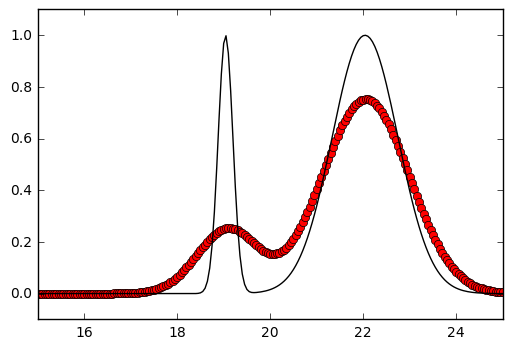

In [2]:
# Implement Lax-Friedrichs for the PDE u_t + u_x = 0 on a periodic
# domain
u_true = lambda x, t: numpy.exp(-20.0 * ((x - t) - 2.0)**2) + numpy.exp(-((x - t) - 5.0)**2)

m = 501
x = numpy.linspace(0, 25.0, m)
delta_x = 25.0 / (m - 1)
cfl = 0.8
delta_t = cfl * delta_x

U = u_true(x, 0)
U_new = numpy.empty(U.shape)
t = 0.0
t_final = 17.0
while t < t_final:
    U_new[0] = 0.5 * (U[1] + U[-1]) - delta_t / (2.0 * delta_x) * (U[1] - U[-1])
    U_new[1:-1] = 0.5 * (U[2:] + U[:-2]) - delta_t / (2.0 * delta_x) * (U[2:] - U[:-2])
    U_new[-1] = 0.5 * (U[0] + U[-2]) - delta_t / (2.0 * delta_x) * (U[0] - U[-2])
    U = U_new.copy()
    t += delta_t
    
# Plot solution at t = 17.0 and t = 0.0
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(x, U, 'ro')
axes.plot(x, u_true(x, t),'k')
axes.set_xlim((15.0, 25.0))
axes.set_ylim((-0.1, 1.1))

plt.show()

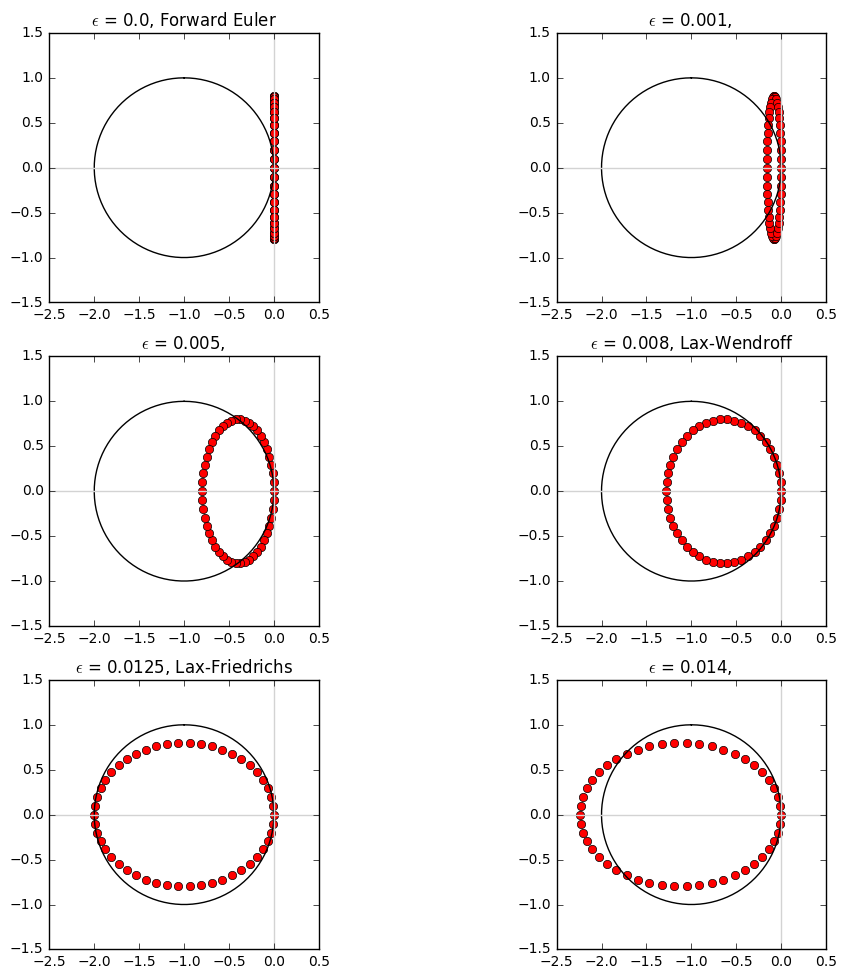

In [4]:
# Plot eigenvalues of the matrix A_\epsilon and plot relative 
# absolute stability region

def construct_A(epsilon, a=1.0, delta_x=0.02):
    """Construct the matrix A from Leveque (10.15)
    """
    e = numpy.ones(int(1.0 / delta_x))
    A = numpy.diag(e[1:], 1) - numpy.diag(e[1:], -1)
    A[0, -1] = -1
    A[-1, 0] = 1
    
    B = numpy.diag(-2.0 * e, 0) + numpy.diag(e[1:], 1) + numpy.diag(e[1:], -1)
    B[0, -1] = 1
    B[-1, 0] = 1
    
    return -a / (2.0 * delta_x) * A + epsilon / delta_x**2 * B
    
delta_x = 0.02
delta_t = 0.8 * delta_x
a = 1.0
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 4)
titles = ["Forward Euler", "", "", "Lax-Wendroff", "Lax-Friedrichs", ""]
for (i, epsilon) in enumerate((0.0, 0.001, 0.005, 0.008, 0.0125, 0.014)):
    axes = fig.add_subplot(4, 2, i + 1, aspect='equal')
    
    # Plot eigenvalues
    eigenvalues = numpy.linalg.eigvals(construct_A(epsilon, a, delta_x))
    axes.plot(delta_t * eigenvalues.real, delta_t * eigenvalues.imag, 'ro')
    
    # Plot offset circle
    theta = numpy.linspace(0.0, 2.0 * numpy.pi, 100)
    axes.plot(numpy.sin(theta) - 1.0, numpy.cos(theta), 'k')
    
    axes.set_xlim((-2.5, 0.5))
    axes.set_ylim((-1.5, 1.5))
    axes.set_title("$\epsilon$ = %s, %s" % (epsilon, titles[i]))
    
    axes.plot([-2.5, 0.5], [0.0, 0.0], color='lightgray')
    axes.plot([0.0, 0.0], [-1.5, 1.5], color='lightgray')
    
plt.show()

### Example:  Leapfrog

For the leapfrog (midpoint) method
$$
    U^{n+1}_j = U^{n-1}_j - \frac{a \Delta t}{\Delta x} (U^n_{j+1} - U^n_{j-1})
$$
we know that its stability region is the interval along the imaginary axis $z \in [-i, i]$.  This implies via method of lines that if
$$
    \left | \frac{a \Delta t}{\Delta x} \right | \leq 1
$$
that this method will be stable.  The one caveat to this is that $z = \Delta t \lambda_p$ will always lie on the boundary of this region (everything does) which means if we see a slight perturbation to the eigenvalues we may be in trouble.  There is no growth but also no decay of any eigenmode of the approximation, also known as being *nondissipative*.  This is not a bad behavior per se, the advection equation is nondissipative itself, but the other problem is that the modes move at different speeds rather than at the one dictated by $a$ leading to dispersive error.  This can also be difficult if the problem is something more complex than the advection equation (inhomogeneous or nonlinear problems for instance).

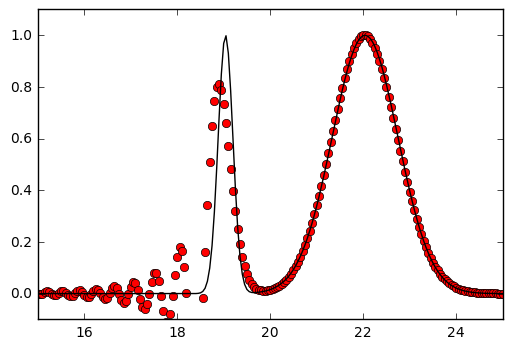

In [5]:
# Implement Leapfrog for the PDE u_t + u_x = 0 on a periodic
# domain
u_true = lambda x, t: numpy.exp(-20.0 * ((x - t) - 2.0)**2) + numpy.exp(-((x - t) - 5.0)**2)

m = 501
x = numpy.linspace(0, 25.0, m)
delta_x = 25.0 / (m - 1)
cfl = 0.8
delta_t = cfl * delta_x

U = u_true(x, 0)
t = 0.0
t_final = 17.0
# Jump start with Lax-Friedrichs
U_new = numpy.empty(U.shape)
U_new[0] = 0.5 * (U[1] + U[-1]) - delta_t / (2.0 * delta_x) * (U[1] - U[-1])
U_new[1:-1] = 0.5 * (U[2:] + U[:-2]) - delta_t / (2.0 * delta_x) * (U[2:] - U[:-2])
U_new[-1] = 0.5 * (U[0] + U[-2]) - delta_t / (2.0 * delta_x) * (U[0] - U[-2])
U_old = U_new.copy()
t += delta_t
while t < t_final:
    U_new[0] = U_old[0] - delta_t / delta_x * (U[1] - U[-1])
    U_new[1:-1] = U_old[1:-1] - delta_t / delta_x * (U[2:] - U[:-2])
    U_new[-1] = U_old[-1] - delta_t / delta_x * (U[0] - U[-2])
    U_old = U.copy()
    U = U_new.copy()
    t += delta_t
    
# Plot solution at t = 17.0 and t = 0.0
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(x, U, 'ro')
axes.plot(x, u_true(x, t),'k')
axes.set_xlim((15.0, 25.0))
axes.set_ylim((-0.1, 1.1))

plt.show()

## The Lax-Wendroff Method

So far the only method that we have used that was second order in space **and** time was the leapfrog discretization but that we saw that we had issues with its nondissipative behavior while also being multi-step method.  Let's explore another approach that is still a one-step method.  Consider the following options:

1. Make the method implicit (trapezoidal rule)
2. Use a Runge-Kutta method (RK 2)
3. Use a Taylor series method

1. Make the method implicit (trapezoidal rule) - We have already mentioned that we should not need to use an implicit method since the advection equation (and many hyperbolic PDEs) are not stiff.
2. Use a Runge-Kutta method (RK 2) - This becomes complex near boundaries and may again require extra storage as with leapfrog
3. Use a Taylor series method - This may require multiple evaluations of the spatial discretization but leads to what's called the *Lax-Wendroff method*.

Take a bit of time and see if you can derive the Lax-Wendroff method by expanding in the time derivative and using a second-order spatial discretization via a method-of-lines approach.

Expanding in time using a Taylor series leads to the system of ODEs
$$
    U^{n+1} = U^n + \Delta t A U^n + \frac{\Delta t^2}{2} A^2 U^n + \mathcal{O}(\Delta t^3)
$$
where $A$ is the matrix derived from our original second order, centered difference approximation.  

Writing this out gives us the update formula
$$
    U^{n+1}_j = U^n_j + \frac{a \Delta t}{2 \Delta x} (U^n_{j+1} - U^n_{j-1} ) + \frac{a^2 \Delta t^2}{2 \Delta x^2} (U^n_{j-2} - 2 U^n_{j} + U^n_{j+2}).
$$
Note that the stencil has now become wider in space due to the $A^2$ term and may pose issues with boundaries.

Instead we could observe that the last term looks like an approximation to $u_{xx}$ and instead of using the wider stencil, use the more familiar stencil.  Instead of doing the above that matches the method of lines approach we can instead use Taylor expansions on the original PDE and simply keep more terms (similar to Taylor expansion methods discussed earlier) we can derive a simpler method.  

The relevant expansion is
$$
    u(x, t + \Delta t) = u(x,t) + \Delta t u_t(x,t) + \frac{\Delta t^2}{2} u_{tt}(x,t) + \frac{\Delta t^3}{6} u_{ttt}(x,t) + \mathcal{O}(\Delta t^4)
$$
and assuming the required smoothness we can replace the $t$ derivates to $x$ derivatives and the original equation we find
$$
    u(x, t + \Delta t) = u(x,t) - a \Delta t u_x(x,t) + \frac{a^2 \Delta t^2}{2} u_{xx}(x,t) + \frac{a^3 \Delta t^3}{6} u_{xxx}(x,t) + \mathcal{O}(\Delta t^4)
$$

We see that we have a method that has the following approximation
$$\begin{aligned}
    U^{n+1}_j &= U^n_j - a \Delta t D_0 U^n_j + \frac{a^2 \Delta t^2}{2} D_2 U^n_j + \frac{a^3 \Delta t^3}{6} u_{xxx}(x,t) + \mathcal{O}(\Delta t^4) \\
    &= U^n_j - \frac{a \Delta t}{2 \Delta x} (U^n_{j+1} - U^n_{j-1})  + \frac{a^2 \Delta t^2}{2 \Delta x^2} (U^n_{j+1} - 2 U^n_{j} + U^n_{j-1}) + \frac{a^3 \Delta t^3}{6} u_{xxx}(x,t) + \mathcal{O}(\Delta t^4)
\end{aligned}$$
leading to the method
$$
     U^{n+1}_j = U^n_j - \frac{a \Delta t}{2 \Delta x} (U^n_{j+1} - U^n_{j-1})  + \frac{a^2 \Delta t^2}{2 \Delta x^2} (U^n_{j+1} - 2 U^n_{j} + U^n_{j-1}).
$$
From here we see that we indeed can use a small stencil and that the dominant error is dispersive in nature (the third order x-derivative).

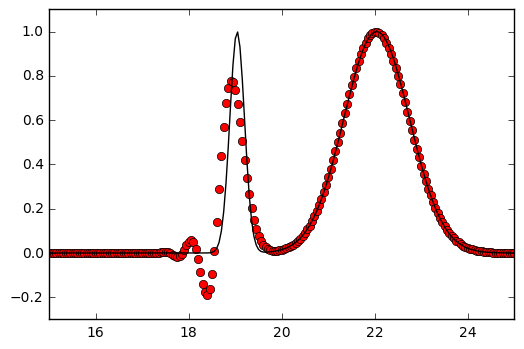

In [2]:
# Implement Lax-Wendroff for the PDE u_t + u_x = 0 on a periodic
# domain
u_true = lambda x, t: numpy.exp(-20.0 * ((x - t) - 2.0)**2) + numpy.exp(-((x - t) - 5.0)**2)

m = 501
x = numpy.linspace(0, 25.0, m)
delta_x = 25.0 / (m - 1)
cfl = 0.8
delta_t = cfl * delta_x

U = u_true(x, 0)
U_new = numpy.empty(U.shape)
t = 0.0
t_final = 17.0
while t < t_final:
    U_new[0] = U[0] - delta_t / (2.0 * delta_x) * (U[1] - U[-1]) \
                    + delta_t**2 / (2.0 * delta_x**2) * (U[1] - 2.0 * U[0] + U[-1])
    U_new[1:-1] = U[1:-1] - delta_t / (2.0 * delta_x) * (U[2:] - U[:-2]) \
                          + delta_t**2 / (2.0 * delta_x**2) * (U[2:] - 2.0 * U[1:-1] + U[:-2])
    U_new[-1] = U[-1] - delta_t / (2.0 * delta_x) * (U[0] - U[-2]) \
                      + delta_t**2 / (2.0 * delta_x**2) * (U[0] - 2.0 * U[-1] + U[-2])
    U = U_new.copy()
    t += delta_t
    
# Plot solution at t = 17.0 and t = 0.0
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(x, U, 'ro')
axes.plot(x, u_true(x, t),'k')
axes.set_xlim((15.0, 25.0))
axes.set_ylim((-0.3, 1.1))

plt.show()

### Stability

Analyzing the Lax-Wendroff method follows from the approach we took to the Lax-Friedrichs method with the consideration of the general method using the $A_\epsilon$ matrix.  Here though instead of $\epsilon = \Delta x^2 / 2 \Delta t$ we use $\epsilon = a^2 \Delta t / 2$.  The eigenvalues of this $A_\epsilon$ are
$$
    \Delta t \lambda_p = -i \frac{a \Delta t}{\Delta x} \sin(p \pi \Delta x) + \left( \frac{a \Delta t}{\Delta x} \right)^2 (\cos(p \pi \Delta x) - 1).
$$
From the numerical example above we see that these lie inside of Euler's method and has the same stability restriction of Lax-Friedrichs.  This is great since we expect Lax-Wendroff to be second order accurate in time and space while Lax-Friedrichs was only first order.

Another observation of note is that the eigenvalues for the Lax-Wendroff method seem to look "optimally" close to the stability region boundary.  This is due the second order nature of the Lax-Wendroff method and has the nice property that it uses the minimal amount of damping needed to remain stable.

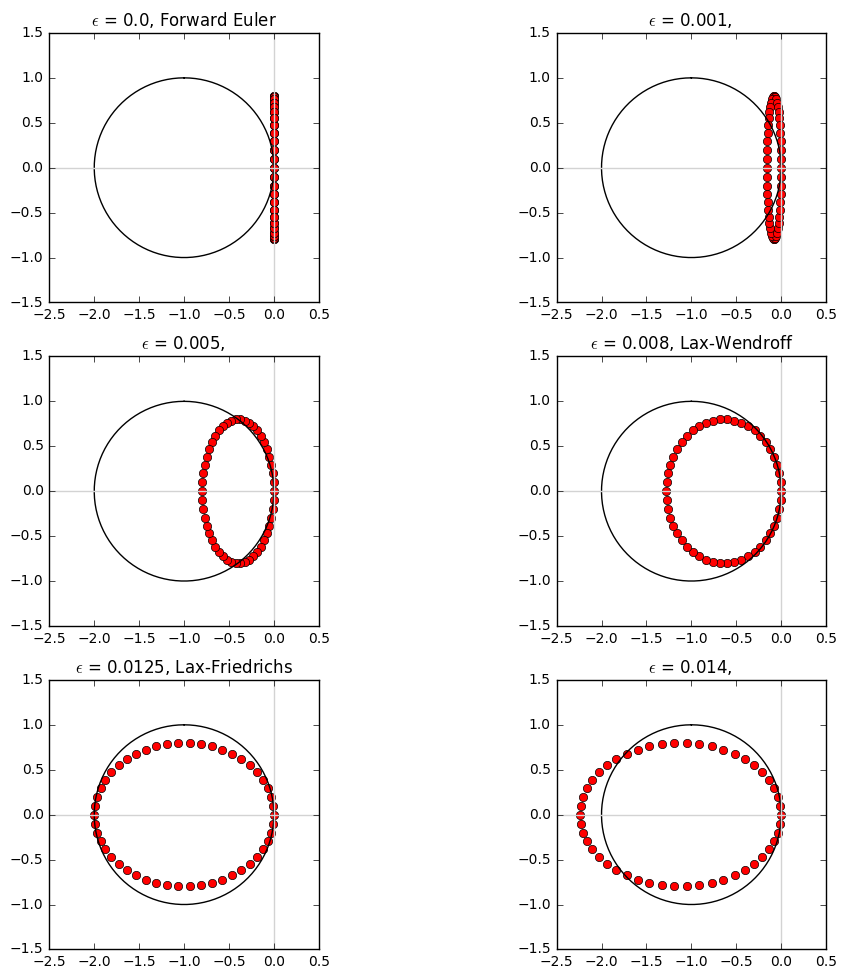

In [3]:
# Plot eigenvalues of the matrix A_\epsilon and plot relative 
# absolute stability region

def construct_A(epsilon, a=1.0, delta_x=0.02):
    """Construct the matrix A from Leveque (10.15)
    """
    e = numpy.ones(int(1.0 / delta_x))
    A = numpy.diag(e[1:], 1) - numpy.diag(e[1:], -1)
    A[0, -1] = -1
    A[-1, 0] = 1
    
    B = numpy.diag(-2.0 * e, 0) + numpy.diag(e[1:], 1) + numpy.diag(e[1:], -1)
    B[0, -1] = 1
    B[-1, 0] = 1
    
    return -a / (2.0 * delta_x) * A + epsilon / delta_x**2 * B
    
delta_x = 0.02
delta_t = 0.8 * delta_x
a = 1.0
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 4)
titles = ["Forward Euler", "", "", "Lax-Wendroff", "Lax-Friedrichs", ""]
for (i, epsilon) in enumerate((0.0, 0.001, 0.005, 0.008, 0.0125, 0.014)):
    axes = fig.add_subplot(4, 2, i + 1, aspect='equal')
    
    # Plot eigenvalues
    eigenvalues = numpy.linalg.eigvals(construct_A(epsilon, a, delta_x))
    axes.plot(delta_t * eigenvalues.real, delta_t * eigenvalues.imag, 'ro')
    
    # Plot offset circle
    theta = numpy.linspace(0.0, 2.0 * numpy.pi, 100)
    axes.plot(numpy.sin(theta) - 1.0, numpy.cos(theta), 'k')
    
    axes.set_xlim((-2.5, 0.5))
    axes.set_ylim((-1.5, 1.5))
    axes.set_title("$\epsilon$ = %s, %s" % (epsilon, titles[i]))
    
    axes.plot([-2.5, 0.5], [0.0, 0.0], color='lightgray')
    axes.plot([0.0, 0.0], [-1.5, 1.5], color='lightgray')
    
plt.show()

## Upwind Methods

One aspect of the simple advection equation we are considering that has yet to be exploited is the asymmetry in the equation due to $a$.  If $a > 0$ then waves propagate to the right and if $a < 0$ they propagate to the left.  This suggests that perhaps a one-sided difference may be sufficient to approximate the solution rather than the centered approximations we have up until now considered.

Consider the one-sided differences
$$
    u_x(x_j, t) \approx \frac{1}{\Delta x} (U_j - U_{j-1}) ~~~~ \text{and} ~~~~ u_x(x_j, t) \approx \frac{1}{\Delta x} (U_{j+1} - U_{j})
$$
that are both first-order accurate approximations to the first derivative.  Using these in conjunction with a forward Euler time stepping scheme leads to
$$
    U^{n+1}_j = U^n_j - \frac{a \Delta t}{\Delta x} (U^n_j - U^n_{j-1}) ~~~~ \text{or} ~~~~ U^{n+1}_j = U^n_j - \frac{a \Delta t}{\Delta x} (U_{j+1} - U_{j})
$$
which are then first order schemes in both time and space.

So how do we exploit the asymmetry mentioned due to $a$ and our one sided differences?

The true solution of the advection equation at the point $(x_j, t + \Delta t)$ is
$$
    u(x_j, t + \Delta t) = u(x_j - a \Delta t, t)
$$
representing the idea that the value of the solution at $u(x_j, t)$ is "flowing" to the new point (following the characteristics).  In the case where $a > 0$ the solution is being dictated by a point to the left of $x_j$, specifically at $x_j - a \Delta t$.  If $a < 0$ it then is determined by a point to the right of $x_j$.  

This suggests that we may want to use the method
$$
    U^{n+1}_j = U^n_j - \frac{a \Delta t}{\Delta x} (U^n_j - U^n_{j-1})
$$
if $a > 0$ and
$$
    U^{n+1}_j = U^n_j - \frac{a \Delta t}{\Delta x} (U_{j+1} - U_{j})
$$
if $a < 0$.  These methods are called *upwind methods* because they use points "upwind" of the current point to find the solution.

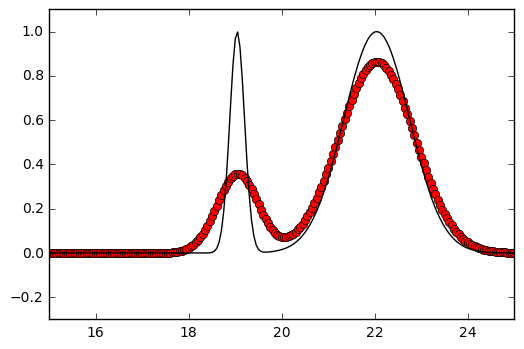

In [4]:
# Implement the Upwind method for the PDE u_t + u_x = 0 on a periodic
# domain
u_true = lambda x, t: numpy.exp(-20.0 * ((x - t) - 2.0)**2) + numpy.exp(-((x - t) - 5.0)**2)

m = 501
x = numpy.linspace(0, 25.0, m)
delta_x = 25.0 / (m - 1)
cfl = 0.8
delta_t = cfl * delta_x

U = u_true(x, 0)
U_new = numpy.empty(U.shape)
t = 0.0
t_final = 17.0
while t < t_final:
    U_new[0] = U[0] - delta_t / delta_x * (U[0] - U[-1])
    #U_new[1:-1] = U[1:-1] - delta_t / delta_x * (U[1:-1] - U[:-2])
    #U_new[-1] = U[-1] - delta_t / delta_x * (U[-1] - U[-2])
    #Periodic boundaries will wrap in vectorized operation anyways
    U_new[1:] = U[1:] - delta_t / delta_x * (U[1:] - U[:-1])
    U = U_new.copy()
    t += delta_t
    
# Plot solution at t = 17.0 and t = 0.0
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(x, U, 'ro')
axes.plot(x, u_true(x, t),'k')
axes.set_xlim((15.0, 25.0))
axes.set_ylim((-0.3, 1.1))

plt.show()

### Stability

Let's now examine the stability of these upwind methods.  We can rewrite the upwind method for $a > 0$ with
$$
    U^{n+1}_j = U^n_j - \frac{a \Delta t}{2 \Delta x} (U^n_j - U^n_{j-1}) + \frac{a \Delta t}{2 \Delta x} (U^n_{j+1} - 2 U^n_j + U^n_{j-1})
$$
leading to an effective $\epsilon = a \Delta x / 2$.  

We know from our method of lines analysis that a method like this will be stable if
$$
    \left |\frac{a \Delta t}{\Delta x} \right | \leq 1
$$
and
$$
    -2 < -\frac{2 \epsilon \Delta t}{\Delta x^2} < 0.
$$

For Lax-Friedrichs $\epsilon$ was indepdent of $a$ and Lax-Wendroff $\epsilon$ has $a^2$ so $\epsilon > 0$ so this second condition would be satisfied with appropriate constraints on $\Delta t$ and $\Delta x$ on the lower bound.  For upwind methods this is no longer true as the sign of $a$ can cause $\epsilon < 0$.  In fact this leads to a condition that tells us what form of the upwind method we need to use depending on the sign of $a$.

For the method analyzed above we have
$$
    -2 < -\frac{2 \epsilon \Delta t}{\Delta x^2} < 0 ~~~ \Rightarrow 0 \leq \frac{a \Delta t}{\Delta x} \leq 1
$$
which we know will satisfy the upper bound if $a > 0$.

For the method looking to the right we have the condition
$$
    -2 < -\frac{2 \epsilon \Delta t}{\Delta x^2} < 0 ~~~ \Rightarrow -1 \leq \frac{a \Delta t}{\Delta x} \leq 0.
$$

We can also again plot the eigenvalues of the matrix and see what happens in each case.  Relating these values of $\epsilon$ again back to those for Lax-Friedrichs and Lax-Wendroff we have
$$
    \epsilon_{LW} = \frac{a^2 \Delta t}{2} = \frac{a \Delta x \nu}{2} ~~~~ \epsilon_{UP} = \frac{a \Delta x}{2} ~~~~ \epsilon_{LF} = \frac{\Delta x^2}{2 \Delta t} = \frac{a \Delta x}{2 \nu}
$$
where $\nu = a \Delta t / \Delta x$ (called the Courant number later).  Note that 
$$
    \epsilon_{LW} = \nu \epsilon_{UP} ~~~ \text{and} \epsilon_UP = \nu \epsilon_{LF}
$$
and if $0 < \nu < 1$ then we know that $\epsilon_{LW} < \epsilon_{UP} < \epsilon_{LF}$.  In other words we see again that Lax-Wendroff and Lax-Friedrichs form the bounds on values of $\epsilon$ that remain stable and the upwind method sits in between the two extremes.

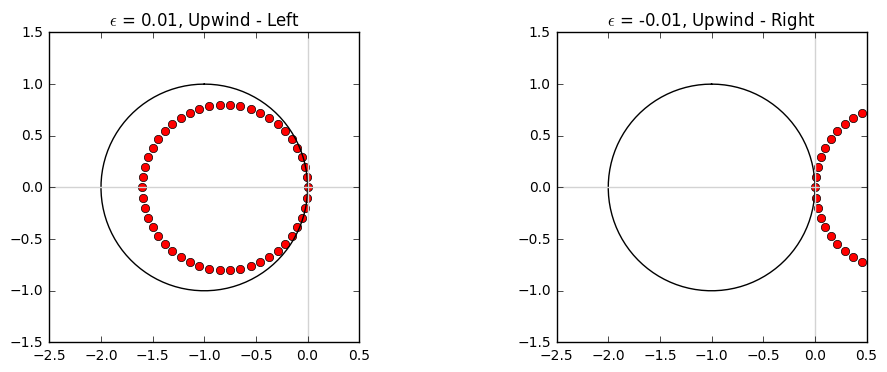

In [6]:
# Plot eigenvalues of the matrix A_\epsilon and plot relative 
# absolute stability region

def construct_A(epsilon, a=1.0, delta_x=0.02):
    """Construct the matrix A from Leveque (10.15)
    """
    e = numpy.ones(int(1.0 / delta_x))
    A = numpy.diag(e[1:], 1) - numpy.diag(e[1:], -1)
    A[0, -1] = -1
    A[-1, 0] = 1
    
    B = numpy.diag(-2.0 * e, 0) + numpy.diag(e[1:], 1) + numpy.diag(e[1:], -1)
    B[0, -1] = 1
    B[-1, 0] = 1
    
    return -a / (2.0 * delta_x) * A + epsilon / delta_x**2 * B
    
delta_x = 0.02
delta_t = 0.8 * delta_x
a = 1.0
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
titles = ["Upwind - Left", "Upwind - Right"]
for (i, epsilon) in enumerate((a * delta_x / 2.0, -a * delta_x / 2.0)):
    axes = fig.add_subplot(1, 2, i + 1, aspect='equal')
    
    # Plot eigenvalues
    eigenvalues = numpy.linalg.eigvals(construct_A(epsilon, a, delta_x))
    axes.plot(delta_t * eigenvalues.real, delta_t * eigenvalues.imag, 'ro')
    
    # Plot offset circle
    theta = numpy.linspace(0.0, 2.0 * numpy.pi, 100)
    axes.plot(numpy.sin(theta) - 1.0, numpy.cos(theta), 'k')
    
    axes.set_xlim((-2.5, 0.5))
    axes.set_ylim((-1.5, 1.5))
    axes.set_title("$\epsilon$ = %s, %s" % (epsilon, titles[i]))
    
    axes.plot([-2.5, 0.5], [0.0, 0.0], color='lightgray')
    axes.plot([0.0, 0.0], [-1.5, 1.5], color='lightgray')
    
plt.show()

### Beam-Warming Method

You may have been disconcerted that we have reverted back to a first order method again but do not fear, the *Beam-Warming method* is a second order accurate method with the same type of one-sided properties.  If we go back to the expansion we found when deriving the Lax-Wendroff method
$$
    u(x, t + \Delta t) = u(x,t) - a \Delta t u_x(x,t) + \frac{a^2 \Delta t^2}{2} u_{xx}(x,t) + \frac{a^3 \Delta t^3}{6} u_{xxx}(x,t) + \mathcal{O}(\Delta t^4)
$$
and approximate the derivatives using one-sided differences rather than centered we get for $a > 0$
$$
    U^{n+1}_j = U^n_j - \frac{a \Delta t}{2 \Delta x} (3 U^n_j - 4 U^n_{j-1} + U^n_{j-2}) + \frac{a^2 \Delta t^2}{2 \Delta x^2} (U^n_j - 2 U^n_{j-1} + U^n_{j-2})
$$
and for $a < 0$
$$
    U^{n+1}_j = U^n_j - \frac{a \Delta t}{2 \Delta x} (-3 U^n_j + 4 U^n_{j+1} - U^n_{j+2}) + \frac{a^2 \Delta t^2}{2 \Delta x^2} (U^n_j - 2 U^n_{j+1} + U^n_{j+2}).
$$
These methods are stable if $0 \leq \nu \leq 2$ and $-2 \leq \nu \leq 0$ respectively.

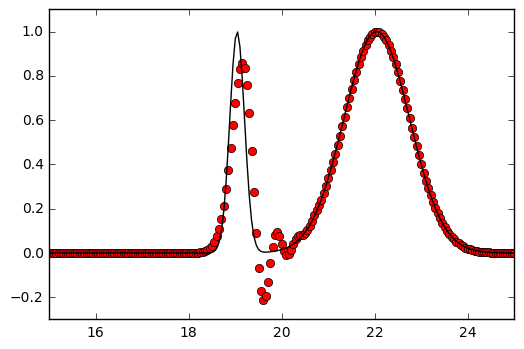

In [7]:
# Implement the Beam-Warming method for the PDE u_t + u_x = 0 on a periodic
# domain
u_true = lambda x, t: numpy.exp(-20.0 * ((x - t) - 2.0)**2) + numpy.exp(-((x - t) - 5.0)**2)

m = 501
x = numpy.linspace(0, 25.0, m)
delta_x = 25.0 / (m - 1)
cfl = 0.8
delta_t = cfl * delta_x

U = u_true(x, 0)
U_new = numpy.empty(U.shape)
t = 0.0
t_final = 17.0
while t < t_final:
    U_new[0] = U[0] - delta_t / (2.0 * delta_x) * (3.0 * U[0] - 4.0 * U[-1] + U[-2]) \
                + delta_t**2 / (2.0 * delta_x**2) * (U[0] - 2.0 * U[-1] + U[-2])
    U_new[1] = U[1] - delta_t / (2.0 * delta_x) * (3.0 * U[1] - 4.0 * U[0] + U[-1]) \
                + delta_t**2 / (2.0 * delta_x**2) * (U[1] - 2.0 * U[0] + U[-1])
    U_new[2:] = U[2:] - delta_t / (2.0 * delta_x) * (3.0 * U[2:] - 4.0 * U[1:-1] + U[:-2]) \
                      + delta_t**2 / (2.0 * delta_x**2) * (U[2:] - 2.0 * U[1:-1] + U[:-2])
    U = U_new.copy()
    t += delta_t
    
# Plot solution at t = 17.0 and t = 0.0
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(x, U, 'ro')
axes.plot(x, u_true(x, t),'k')
axes.set_xlim((15.0, 25.0))
axes.set_ylim((-0.3, 1.1))

plt.show()

## Von Neumann Analysis

We now try to derive similar constraints as we saw with the method of lines discretization but using von Neumann analysis instead.

Recall that von Neumann analysis proceeded by replacing $U^n_j$ with $g(\xi)^n e^{i \xi j \Delta x}$ and finding an expression for the amplification factor $g(\xi)$.  If the amplification factor satisfies
$$
    \left|g(\xi)\right| \leq 1
$$
then we know the method is stable.

Below we will also introduce the notation
$$
    \nu \equiv \frac{a \Delta t}{\Delta x}
$$
as it will be useful later on.

### Example - Upwind

The upwind method for $a > 0$ is 
$$
    U^{n+1}_j = U^n_j - \frac{a \Delta t}{\Delta x}(U^n_{j} - U^n_{j - 1}).
$$
Derive the amplification factor and the resulting stability condition.

Plugging in the plane-wave solution we have
$$\begin{aligned}
    g(\xi) &= 1 - \frac{a \Delta t}{\Delta x} (1 - e^{-i \xi \Delta x}) \\
    &= (1 - \nu) + \nu e^{-i \xi \Delta x}.
\end{aligned}$$
This amplification factor varies with the wave number $\xi$ such that it traces out a circle of radius $\nu$ centered at $1 - \nu$.  Note that if $\nu = 1$ the circle is centered at the origin and has radius 1, i.e. the unit ball.  In other words they are on the edge of being stable.  The other extreme with $\nu = 0$ is not quite so interesting (since this is a trivial case with $a = 0$).  The conclusion then is that for stability the upwind method must have
$$
    0 \leq \nu \leq 1.
$$

For the case $a < 0$ we find the analogous case with $-1 \leq \nu \leq 0$. 

### Example - Lax-Wendroff

Derive the amplification factor for the Lax-Wendroff method
$$
     U^{n+1}_j = U^n_j - \frac{a \Delta t}{2 \Delta x} (U^n_{j+1} - U^n_{j-1})  + \frac{a^2 \Delta t^2}{2 \Delta x^2} (U^n_{j+1} - 2 U^n_{j} + U^n_{j-1})
$$

$$\begin{aligned}
    g(\xi) &= 1 - \frac{\nu}{2} \left(e^{i \xi \Delta x} - e^{-i \xi \Delta x} \right ) + \frac{\nu^2}{2} \left (e^{i \xi \Delta x} - 2 + e^{-i \xi \Delta x} \right ) \\
    &= 1 - i \nu \sin(\xi \Delta x) + \nu^2 (\cos(\xi \Delta x) - 1) \\
    &= 1 - i \nu 2\sin(\xi \Delta x / 2) \cos(\xi \Delta x / 2) - \nu^2 2\sin(\xi \Delta x / 2)
\end{aligned}$$
(the last line is written so that we can easily take the modulus).

$$\begin{aligned}
    |g(\xi)|^2 &= (1 - 2\nu^2 \sin^2(\xi \Delta x / 2) )^2 + 4 \nu^2 \sin^2(\xi \Delta x / 2) \cos^2(\xi \Delta x / 2) \\
    &= 1 + 4 \nu^2 \sin^2(\xi \Delta x / 2) (\cos^2(\xi \Delta x / 2) - 1) + 4\nu^4 \sin^4(\xi \Delta x / 2) \\
    &=1 -4 \nu^2 (1 - \nu^2) \sin^4(\xi \Delta x / 2).
\end{aligned}$$
We know $0 \leq \sin^4(\xi \Delta x / 2) \leq 1$ for any $\xi$ see we need $|\nu| \leq 1$ for the method to be stable.

### Example - Lax-Friedrichs

Derive the amplification factor for Lax-Friedrichs
$$
    U^{n+1}_j = \frac{1}{2}(U^n_{j-1} + U^n_{j+1}) - \frac{a \Delta t}{2 \Delta x} (U^n_{j+1} - U^n_{j-1}).
$$

$$\begin{aligned}
    g(\xi) &= \frac{1}{2} (e^{i \xi \Delta x} + e^{-i \xi \Delta x}) - \frac{\nu}{2} (e^{i \xi \Delta x} - e^{-i \xi \Delta x}) \\
    &= \cos(\xi \Delta x) - i \nu \sin(\xi \Delta x)
\end{aligned}$$
leading to
$$
    |g(\xi)|^2 = \cos^2(\xi \Delta x) + \nu^2 \sin^2 (\xi \Delta x)
$$
and therefore the condition that $|\nu| \leq 1$.

### Example - Leapfrog

A bit more tricky but doable, derive the amplification factor and stability criteria for the leapfrog method
$$
    U^{n+1}_j = U^{n-1}_j - \frac{a \Delta t}{\Delta x} (U^n_{j+1} - U^n_{j-1})
$$

$$\begin{aligned}
     g(\xi)^2 &= 1 - \nu g(\xi) (e^{i \xi \Delta x} - e^{-i \xi \Delta x}) \\
     &= 1- 2 \nu i \sin(\xi \Delta x) g(\xi). 
\end{aligned}$$
This then implies two branches for $g(\xi)$:
$$
    g_{1,2}(\xi) =  - \nu i \sin(\xi \Delta x) \pm \sqrt{1 - \nu^2 \sin^2(\xi \Delta x)}
$$
and therefore a modulus of
$$
    |g_{1,2}(\xi)|^2 =  \nu^2 \sin^2(\xi \Delta x) + ( 1 - \nu^2 \sin^2(\xi \Delta x)) \leq 1
$$
if $|\nu| \leq 1$ again.